# Importing Required Libraries

In [43]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns

Importing the Dataset

In [44]:
data = pd.read_csv('Champagne.csv')
data.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


Creating a date range

In [45]:
dates = pd.date_range(start='1964-01-01', freq='MS', periods=len(data))
dates[0:5]

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [46]:
data.set_index(dates,inplace=True)

In [47]:
sales_ts = data['Sales']
sales_ts[0:5]

1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Freq: MS, Name: Sales, dtype: int64

# Modeling

In [48]:
data = pd.DataFrame(sales_ts.copy())
data.head()

,Sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


# Model 1: Regression on Time

In [49]:
time = [i+1 for i in range(len(data))]

In [50]:
# Splitting Train and Test Length
train_len = int(np.ceil(len(data) * 0.75))
train_len

79

In [51]:
data1 = data.copy()
data1['time'] = time
train=data1[0:train_len] 
test=data1[train_len:]

In [52]:
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 79
Test  data length : 26


In [53]:
x_train = train.drop('Sales',axis=1)
x_test = test.drop('Sales', axis=1)
y_train = train[['Sales']]
y_test = test[['Sales']]

Linear Regression

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
model = LinearRegression()

In [56]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [57]:
predictions = model.predict(x_test)

In [58]:
y_test['RegOnTime'] = predictions

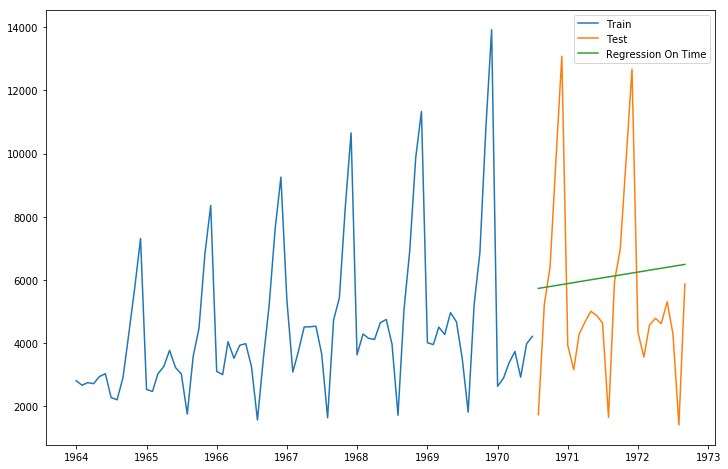

In [59]:
plt.figure(figsize=(12,8))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_test['RegOnTime'], label='Regression On Time')
plt.legend(loc='best')
plt.show()

In [60]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_test.RegOnTime))
rmse = round(rmse, 3)

In [61]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_test['RegOnTime'])
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),3)
resultsDf = pd.DataFrame({'Method':['RegressionOnTime'], 'RMSE': [rmse]})
resultsDf

,Method,RMSE
0,RegressionOnTime,2985.338


In [62]:
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['RegressionOnTime'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,RegressionOnTime,2985.338,0.639


# Model 2: Regression on Time With Seasonal Components

In [63]:
time = [i+1 for i in range(len(data))]
data1 = data.copy()
data1['time'] = time

Adding monthly seasonality in the data

In [64]:
monthSeasonality = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']

In [65]:
even = monthSeasonality*8 
last = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9']
data1['monthSeasonality'] = even + last
data1.head(2)

,Sales,time,monthSeasonality
1964-01-01,2815,1,m1
1964-02-01,2672,2,m2


In [66]:
data1Complete = pd.get_dummies(data1, drop_first=True)
data1Complete.head(2).T

,1964-01-01 00:00:00,1964-02-01 00:00:00
Sales,2815,2672
time,1,2
monthSeasonality_m10,0,0
monthSeasonality_m11,0,0
monthSeasonality_m12,0,0
monthSeasonality_m2,0,1
monthSeasonality_m3,0,0
monthSeasonality_m4,0,0
monthSeasonality_m5,0,0
monthSeasonality_m6,0,0


In [67]:
#Creating train and test set 
train=data1Complete[0:train_len] 
test=data1Complete[train_len:]

In [68]:
x_train = train.drop('Sales', axis=1)
x_test = test.drop('Sales', axis=1)
y_train = train[['Sales']]
y_test = test[['Sales']]

In [69]:
model = LinearRegression()

In [70]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [71]:
predictions = model.predict(x_test)

In [72]:
y_test['RegOnTimeSeasonal'] = predictions

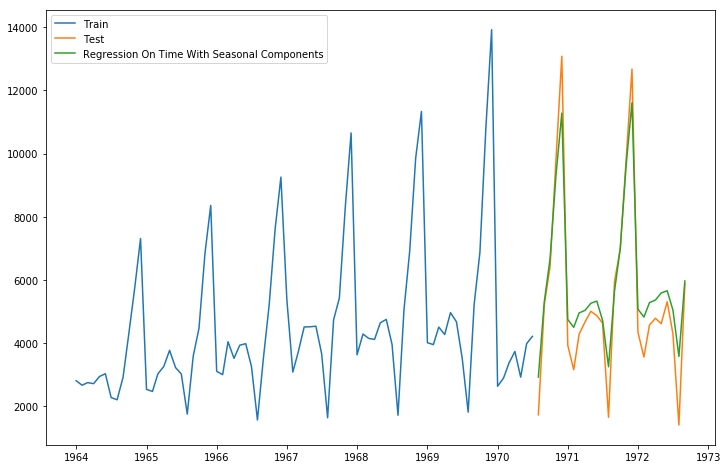

In [73]:
plt.figure(figsize=(12,8))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_test['RegOnTimeSeasonal'], label='Regression On Time With Seasonal Components')
plt.legend(loc='best')
plt.show()

In [74]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_test.RegOnTimeSeasonal))
rmse = round(rmse, 3)

In [75]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_test['RegOnTimeSeasonal'])
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)

In [76]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['RegressionOnTimeSeasonal'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,RegressionOnTime,2985.338,0.6390
0,RegressionOnTimeSeasonal,907.877,0.2262


# Model 3: Naive Approach:  

In [77]:
dd= np.asarray(train.Sales)

In [78]:
y_hat = test.copy() 

In [79]:
y_hat['naive'] = dd[len(dd)-1]

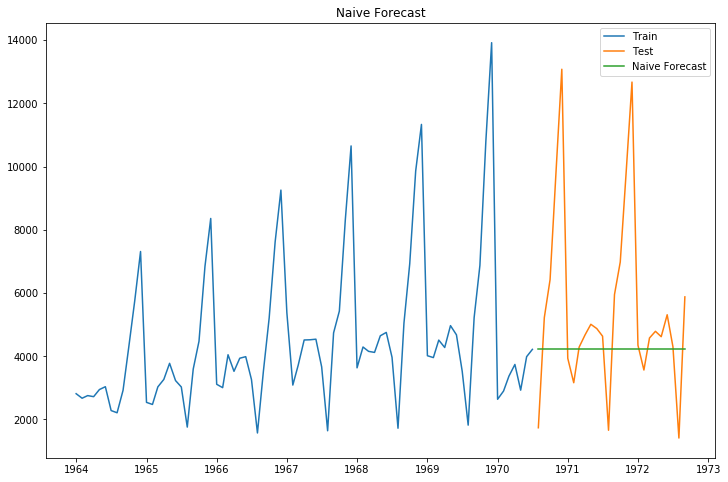

In [80]:
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Sales'], label='Train')
plt.plot(test.index,test['Sales'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [81]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat.naive))
rmse = round(rmse, 3)

In [82]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_hat.naive)
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)

In [83]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Naive forecast'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,RegressionOnTime,2985.338,0.6390
0,RegressionOnTimeSeasonal,907.877,0.2262
0,Naive forecast,3150.443,0.4066


Naive's scores are the base score for a model since it is taking just the previous value of the series.
Linear Regression with Time and Seasonal has shown better performance than on Time.